<img src="../files/misc/logo.gif" width=300/>
<h1 style="color:#872325">Unsupervised Learning </h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import randn, seed
from scipy.linalg import norm
from sklearn.datasets import make_moons
from ipywidgets import interact, FloatSlider, Dropdown, IntSlider
from sklearn.datasets import make_biclusters, make_moons

In [2]:
%config InlineBackend.figure_format = "retina"
import sys
sys.path.append("../files")
import utils

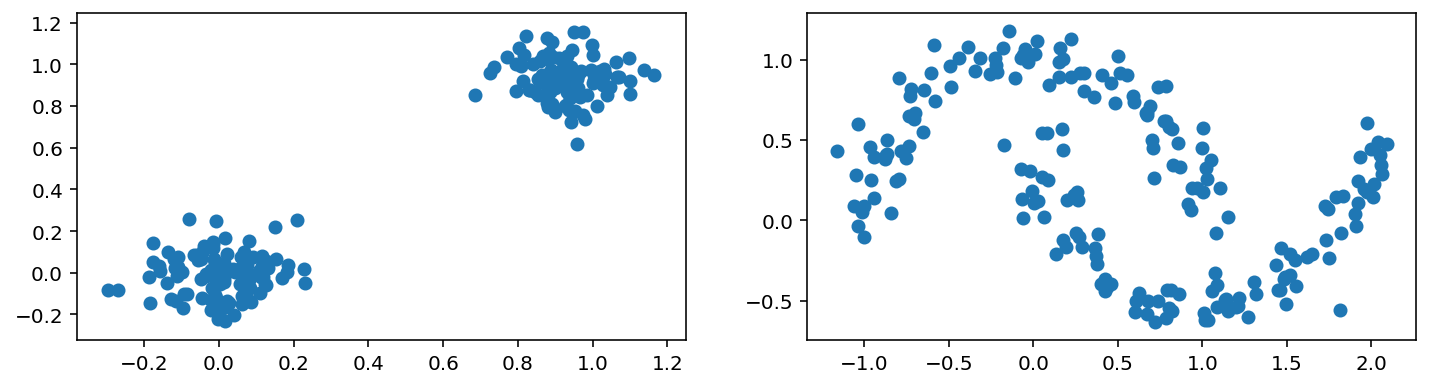

In [3]:
noise = 0.1
X, y, _ = make_biclusters((200, 2), 2, noise=noise, random_state=314, minval=0, maxval=1)
X_moons, y_moons = make_moons(200, noise=noise, random_state=2718)

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].scatter(*X.T)
ax[1].scatter(*X_moons.T)

# K-means

$$
    J(\boldsymbol\mu) = \sum_{n=1}^N\sum_{k=1}^K r_{nk} ||{\bf x}_n - \mu_k||^2
$$

Donde:
* $r_{nk} = \mathbb{1}({\bf x}_n)\in C_k$

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)

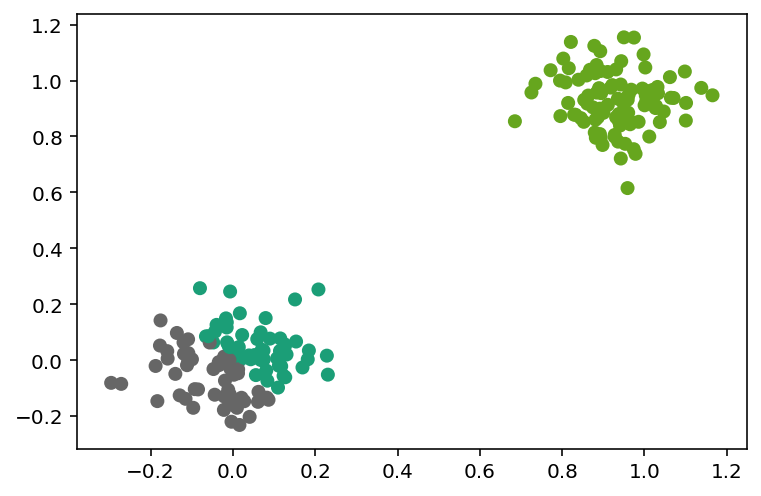

In [5]:
kmeans.fit(X)
plt.scatter(*X.T, c=kmeans.predict(X), cmap="Dark2")

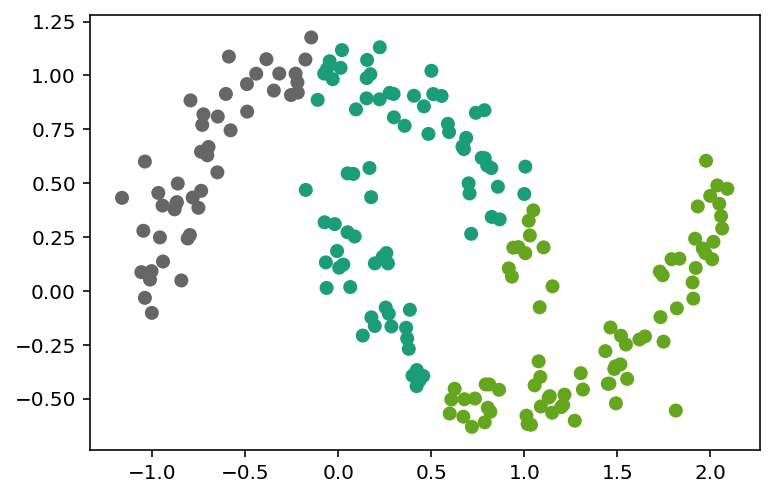

In [6]:
kmeans.fit(X_moons)
plt.scatter(*X_moons.T, c=kmeans.predict(X_moons), cmap="Dark2")

# Hierarchical Clustering

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

In [8]:
Xhist = np.array([[-0.35336868,  0.57168984],
       [ 1.13533174, -0.3396895 ],
       [ 1.05011785,  0.07488545],
       [-1.17901645,  0.05330904],
       [ 2.08252318,  0.27384425]])

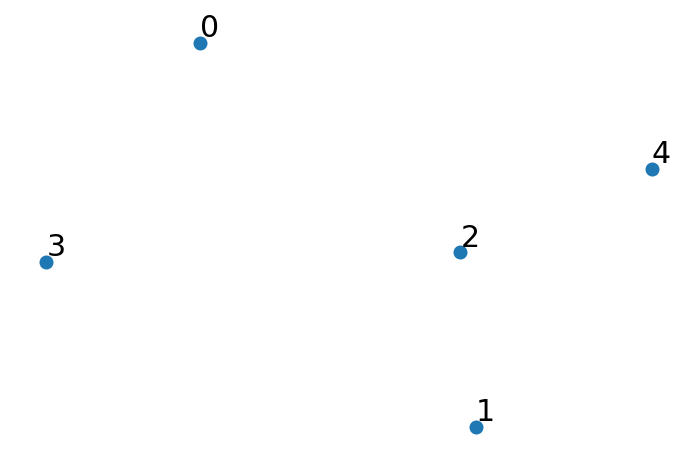

In [9]:
plt.scatter(*Xhist.T)
for i, (x, y) in enumerate(Xhist):
    plt.text(x, y, i, fontsize=15, verticalalignment="bottom")
plt.axis("off");

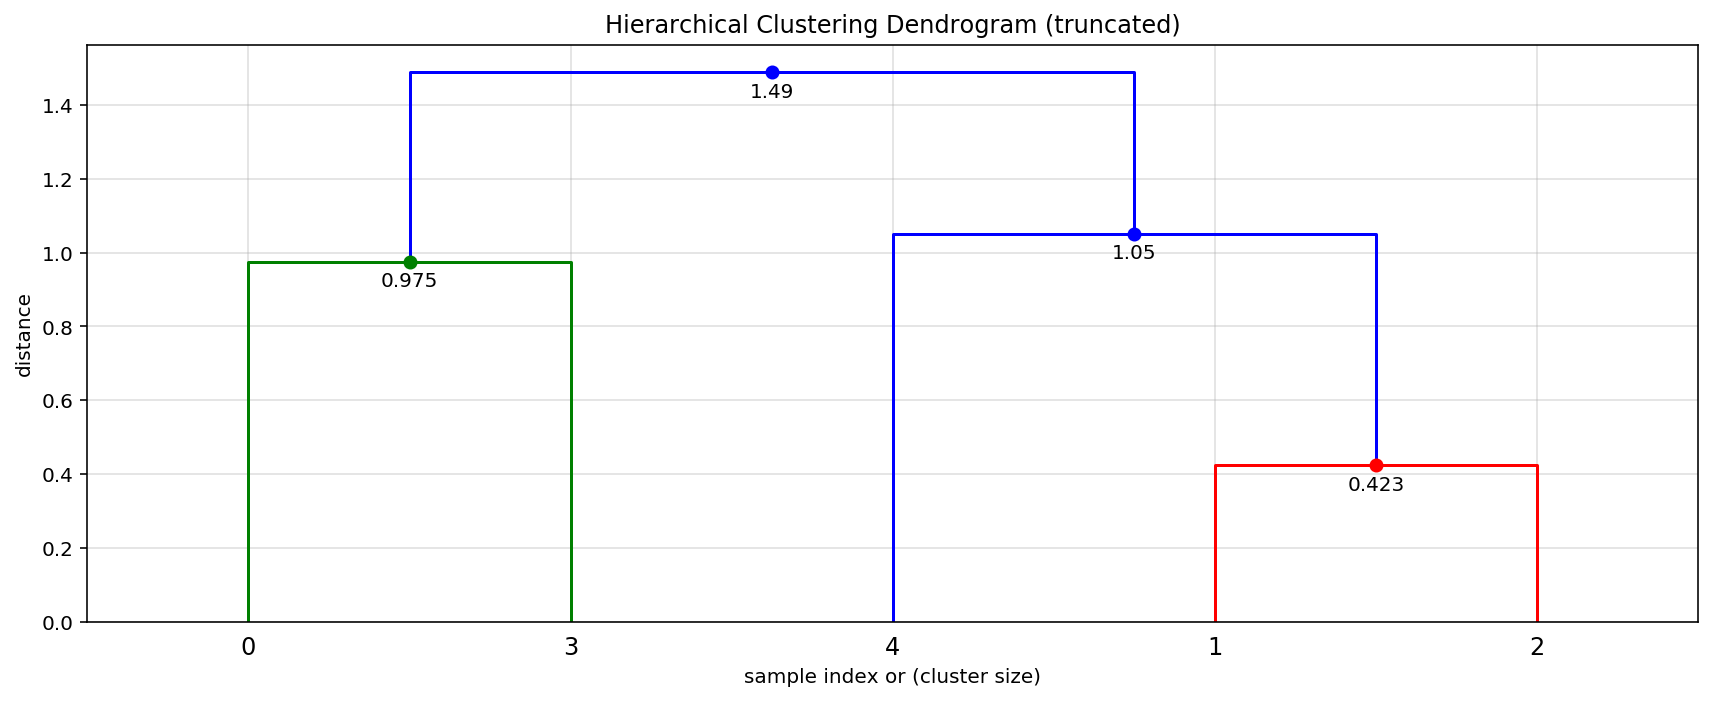

In [10]:
Z = linkage(Xhist, metric="euclidean")
plt.figure(figsize=(12, 5))
utils.fancy_dendrogram(Z,
                 p=10,
                 truncate_mode="lastp",
                 annotate_above=0.001);
plt.grid(alpha=0.4)
plt.tight_layout()

In [11]:
# * C0, C1: Agrupaciones Realizadas en la i-ésima iteración
# * C2: Distancia obtenida de la i-ésima agrupación
# * C3: Numero de elementos dentro de la agrupación realizada
Z

array([[1.        , 2.        , 0.42324201, 2.        ],
       [0.        , 3.        , 0.97489122, 2.        ],
       [4.        , 5.        , 1.05140162, 3.        ],
       [6.        , 7.        , 1.48882136, 5.        ]])


**Cophenetic Distance** Prueba de bondad para un dendrograma de que tan bien se correlacionan las distancias originales de los puntos contra los representados por los *clusters*.

In [12]:
# Cophenetic Distance: 
coph, _ = cophenet(Z, pdist(Xhist))
coph

0.8173592938005432

## Ejemplo

In [13]:
X_moons.shape

(200, 2)

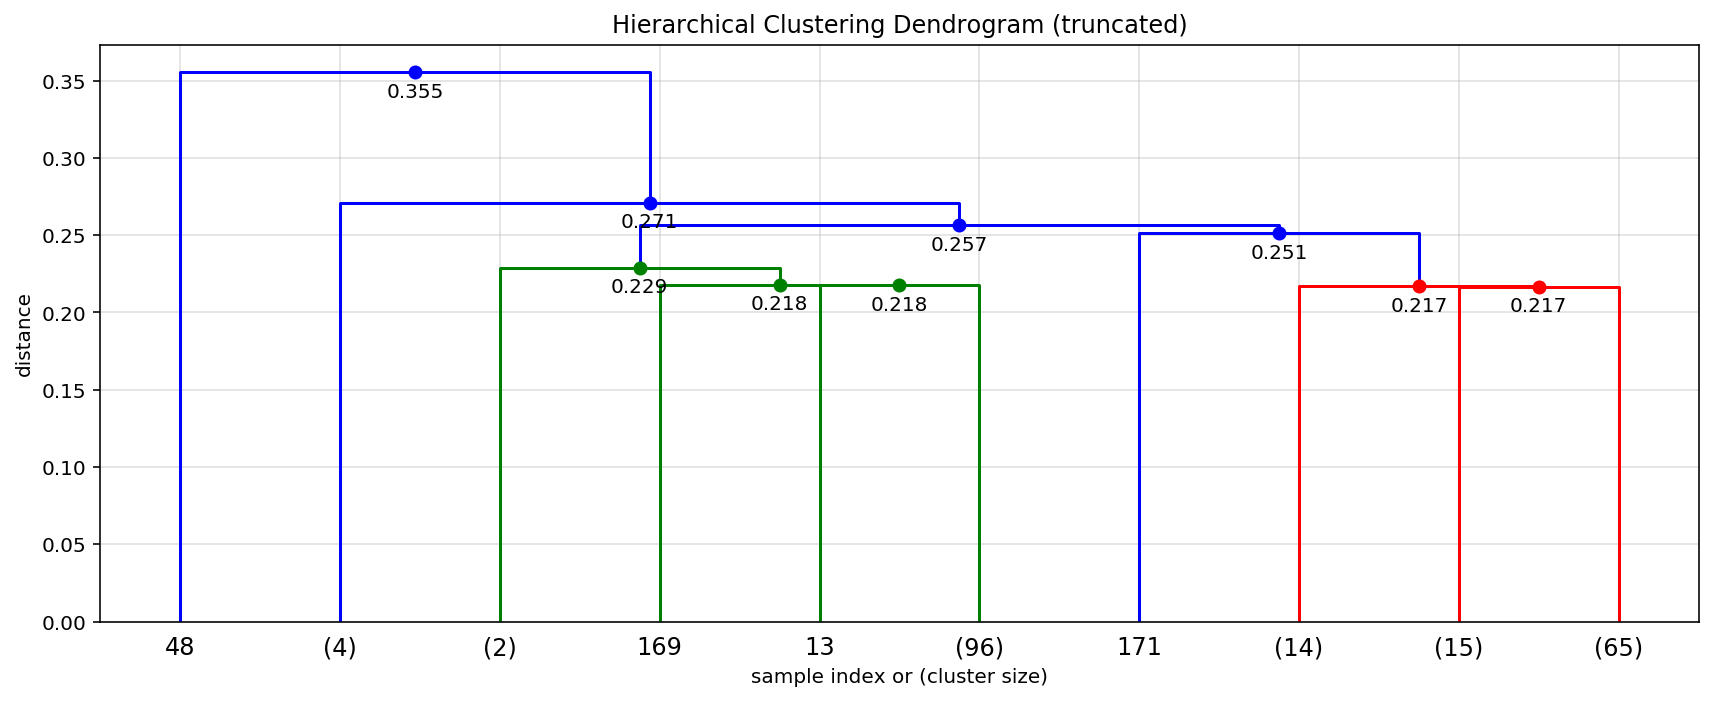

In [14]:
Z = linkage(X_moons, metric="cityblock")
plt.figure(figsize=(12, 5))
utils.fancy_dendrogram(Z,
                 p=10,
                 truncate_mode="lastp",
                 annotate_above=0.001);
plt.grid(alpha=0.4)
plt.tight_layout()

In [15]:
clusters = fcluster(Z, 4, criterion="maxclust")

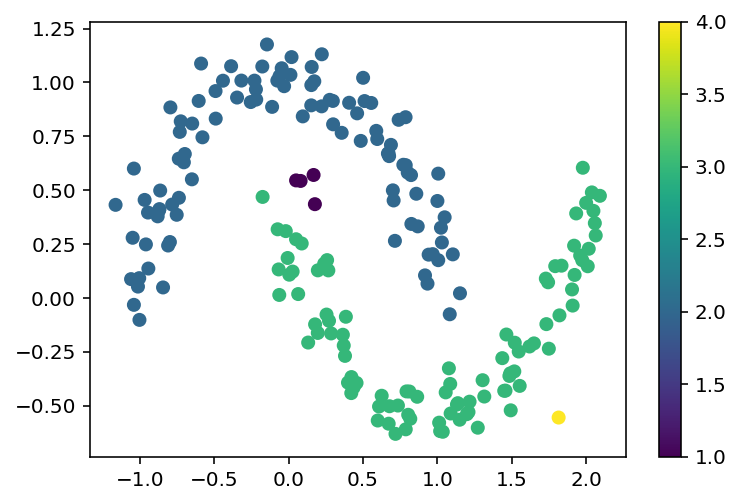

In [16]:
plt.scatter(*X_moons.T, c=clusters, cmap="viridis")
plt.colorbar()

# Kernel Density Estimation

$$
    p(x) = \frac{K}{NV} = \frac{1}{N}\sum_{n=1}^N \frac{k({\bf x}, {\bf x}_n)}{V}
$$

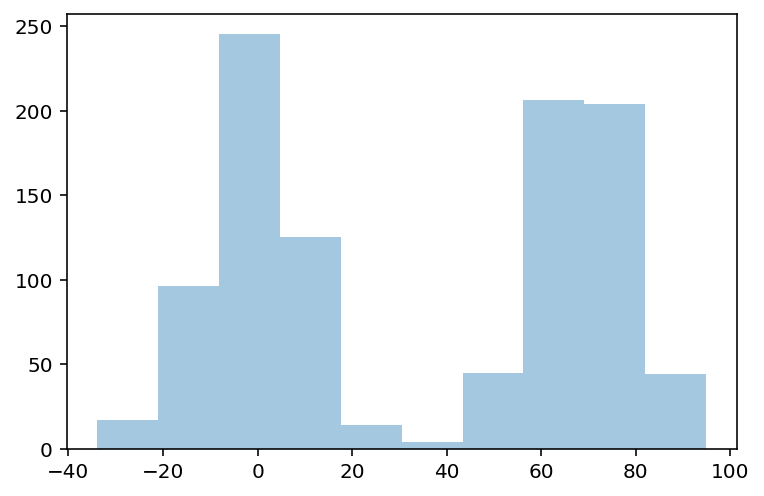

In [17]:
data =  make_biclusters((1000,1), 2, noise=10,
                        random_state=31415)[0].ravel()
sns.distplot(data, kde=False)

In [18]:
def K(u, axis=0): return np.all(np.abs(u) <= 1/2, axis=axis)

def p1(x, X, h):
    """
    KDE under a unit hypercube
    """
    N, D = X.shape
    xden, _ = x.shape
    
    u = ((x - X.T) / h).reshape(D, xden, N)
    ku = K(u).sum(axis=1) / (N * h ** D)
    return ku

def kdeg(x, X, h):
    """
    KDE under a gaussian kernel
    """
    N, D = X.shape
    nden, _ = x.shape # number of density points
    
    Xhat = X.reshape(D, 1, N)
    xhat = x.reshape(D, nden, 1)
    u = xhat - Xhat
    u = norm(u, ord=2, axis=0) ** 2 / (2 * h ** 2) # (N, nden)
    px = np.exp(-u).sum(axis=1) / (N * h * np.sqrt(2 * np.pi))
    return px

In [19]:
xv = np.linspace(-50, 120, 500).reshape(-1, 1)
data_reshaped = data.reshape(-1, 1)
@interact(h=FloatSlider(min=0, max=20, step=0.5, value=10),
          kernel=Dropdown(options=["unit", "gaussian"]))
def gaussian_kde(h, kernel):
    sns.distplot(data_reshaped, kde=False, norm_hist=True)
    
    kde = kdeg(xv, data_reshaped, h) if kernel == "gaussian" else p1(xv, data_reshaped, h)
    plt.plot(xv, kde, c="crimson", alpha=0.7)

interactive(children=(FloatSlider(value=10.0, description='h', max=20.0, step=0.5), Dropdown(description='kern…

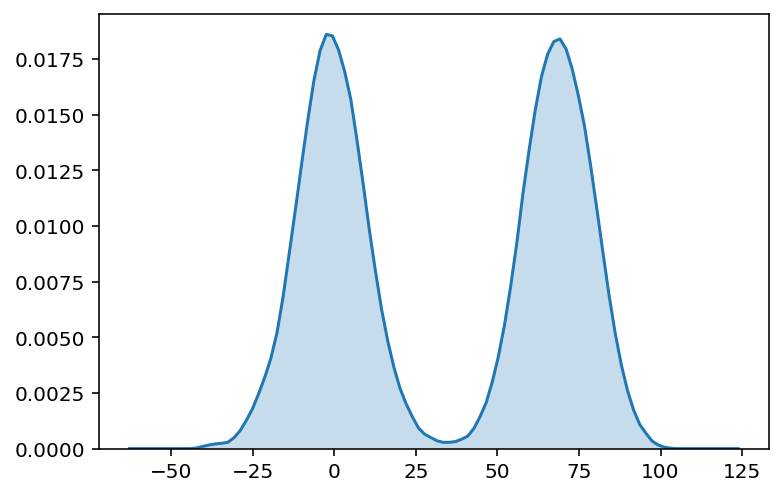

In [20]:
## Dentro de Seaborn
kernels = ["gau", "cos", "biw", "epa", "tri", "triw"]
sns.kdeplot(data.ravel(), kernel=kernels[1], shade=True)

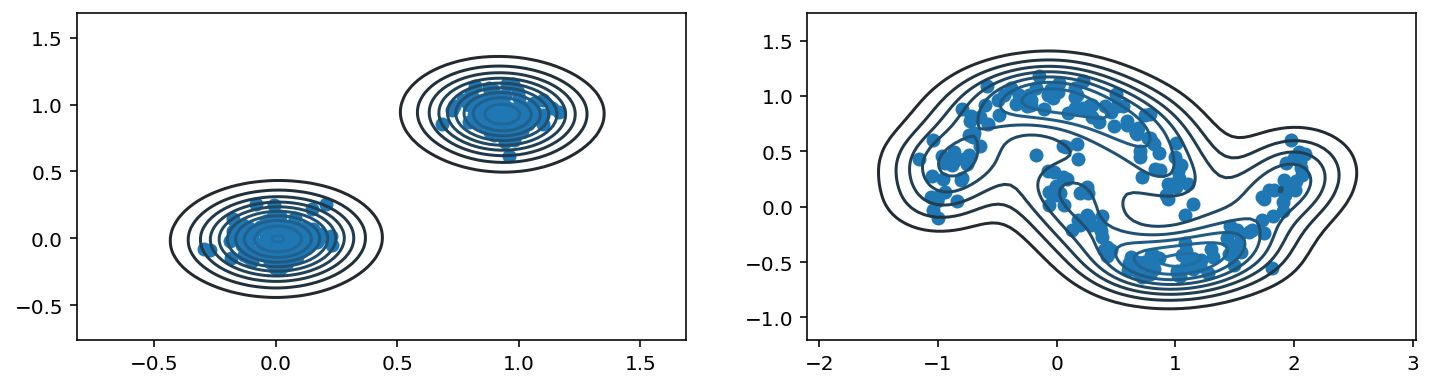

In [21]:
## Dentro de Seaborn

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
sns.kdeplot(*X.T, ax=ax[0])
ax[0].scatter(*X.T)

sns.kdeplot(*X_moons.T, ax=ax[1])
ax[1].scatter(*X_moons.T)

# PCA:
## Análisis de Componentes Principales

In [23]:
from numpy.linalg import svd
# conda install tensorflow
from tensorflow.keras import datasets

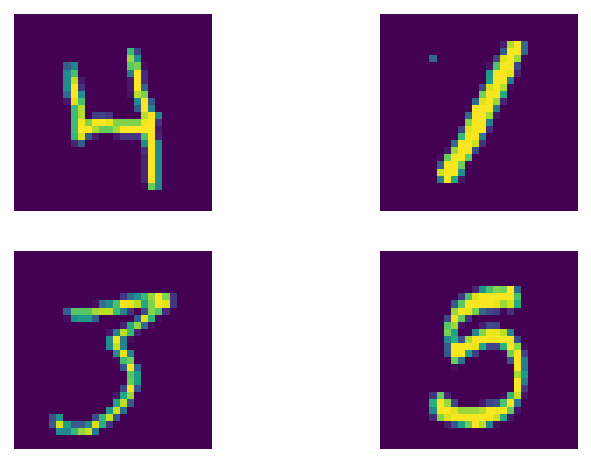

In [24]:
train, test = datasets.mnist.load_data()
xtrain, ytrain = train

np.random.seed(3141)
indices = np.random.choice(np.arange(len(xtrain)), size=4)
fig, ax = plt.subplots(2, 2)
for axi, ix in zip(ax.ravel(), indices):
    axi.imshow(xtrain[ix])
    axi.axis("off")

## Descomposición en valores singulares

$$
\begin{aligned}
    X &= U\Sigma V^T \\
      &= Z V^T
\end{aligned}
$$

In [25]:
xtrain.shape

(60000, 28, 28)

In [26]:
%%time
N, M1, M2 = xtrain.shape
X = xtrain.reshape(N, -1)[:int(N * 0.5)]
y = ytrain[:int(N * 0.5)]
mu = X.mean(axis=0, keepdims=True)
X = X - mu
U, Sigma, Vt = svd(X, full_matrices=False)

CPU times: user 6.42 s, sys: 414 ms, total: 6.84 s
Wall time: 1.86 s


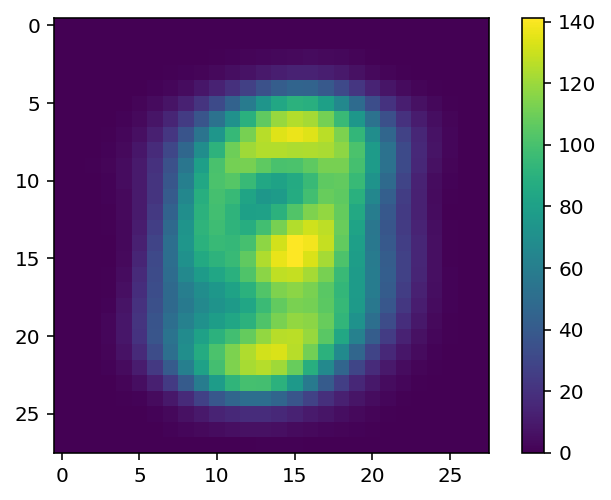

In [27]:
plt.imshow(mu.reshape(M1, M2))
plt.colorbar()

In [28]:
samp = X[0] + mu
Z = U[0] * Sigma
samp_reconstructed = Z @ Vt + mu

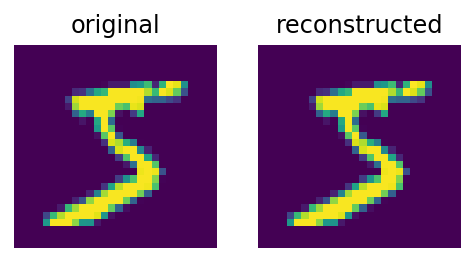

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(4, 12))
labels = ["original", "reconstructed"]
ax[0].imshow(samp.reshape(M1, M2))
ax[1].imshow(samp_reconstructed.reshape(M1, M2))

for lab, axi in zip(labels, ax):
    axi.set_title(lab)
    axi.axis("off")

### Proyectando en $\mathbb{R}^q$

$$
    \hat X = X{\bf V}_d
$$

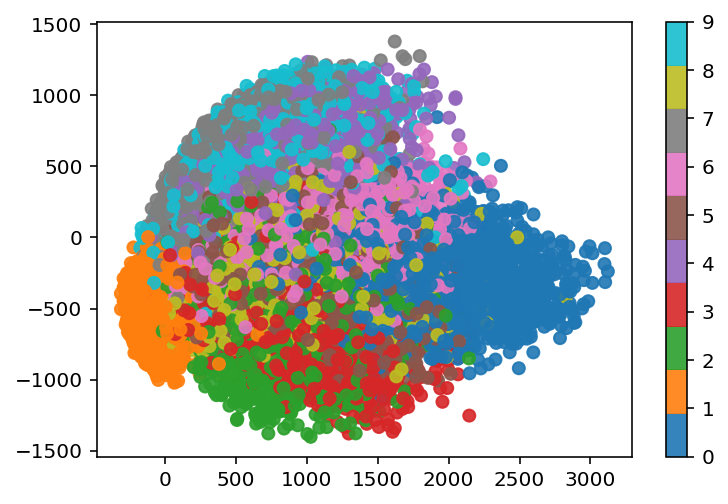

In [30]:
samp = X + mu
proj = samp @ Vt.T[:, :2]
plt.scatter(*proj.T, c=y, cmap="tab10", alpha=0.9)
plt.colorbar()

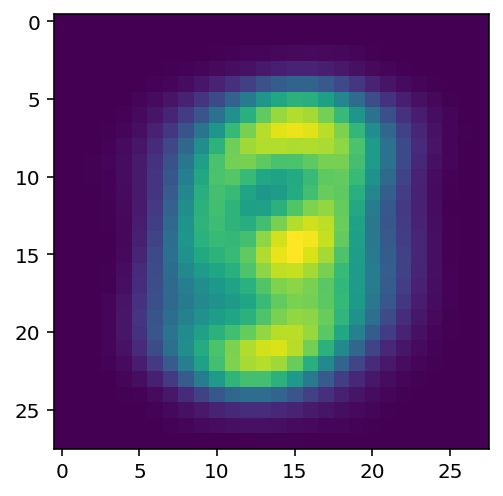

In [31]:
plt.imshow((U[-1] + mu).reshape(M1, M2))

### Reconstruyendo $X$

$$
\hat X = X^{\text{proj}} {\bf V}_d^T
$$

In [32]:
@interact(n_components=IntSlider(min=0, max=200, step=10))
def pca_reconstruct(n_components):
    V2 = Vt.T[:, :n_components]
    samp = X[[0], :] + mu
    recov = (samp @ (V2 @ V2.T)).reshape(-1, M1, M2)
    plt.imshow(recov[0])
    plt.axis("off")

interactive(children=(IntSlider(value=0, description='n_components', max=200, step=10), Output()), _dom_classe…

## PCA en `scikit-learn`

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=50)

x_reduced = pca.fit_transform(xtrain.reshape(N, -1))
x_reduced.shape

(60000, 50)

In [35]:
compressed = pca.inverse_transform(x_reduced)

In [36]:
50 / 760 - 1

-0.9342105263157895

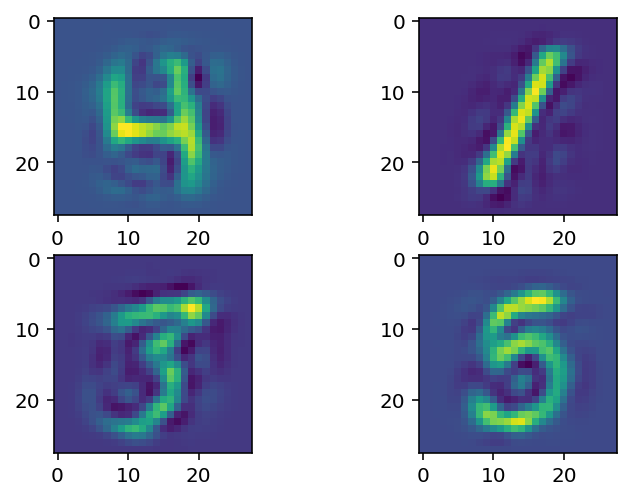

In [37]:
fig, ax = plt.subplots(2, 2)
for axi, ix in zip(ax.ravel(), indices):
    axi.imshow(compressed[ix].reshape(M1, M2))

In [39]:
pca = PCA(n_components=0.95)
N, M1, M2 = xtrain.shape
x_reduced = pca.fit_transform(xtrain.reshape(N, -1))
x_reduced.shape

(60000, 154)

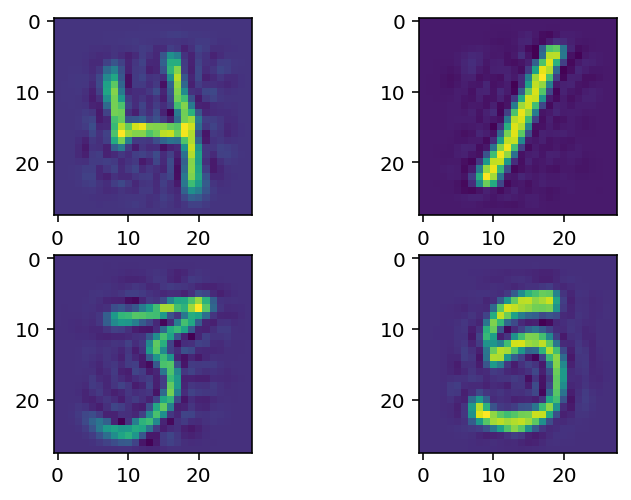

In [40]:
compressed = pca.inverse_transform(x_reduced)
fig, ax = plt.subplots(2, 2)
for axi, ix in zip(ax.ravel(), indices):
    axi.imshow(compressed[ix].reshape(M1, M2))

<h2 style="color:crimson">Ejercicio</h2>

**Entrenando un modelo con PCA**  
Considerando  `xtrain`, `ytrain` definido en las céldas de arriba, crea dos modelos: 
1. Un pipeline considerando PCA con `n_components=0.7` seguido de un modelo `KNeighborsClassifier` con `n_neighbors=5`
2. `KNeighborsClassifier` con `n_neighbors=5`

Realiza un *cross validation* con `n_components=3`.
* ¿Qué resultados arroja cada modelo?
* ¿que ventajas tiene cada modelo?
* ¿Cuánto tarda en correr cada *cross-validation*?